In [41]:
class Matrix:
    pass
class Vector:
    pass

def argmax(iterable) -> int:
    max_index = 0
    max_item = iterable[0]
    for index, item in enumerate(iterable):
        if item > max_item:
            max_index = index
            max_item = item
    return max_index

class Matrix:
    def __init__(self, data):
        self.data = data
        self.m = len(data)          #rows
        self.n = len(data[0])       #cols

    def shape(self) -> tuple[int, int]:
        return self.m, self.n
    
    def T(self) -> Matrix:
        return Matrix([[self.data[j][i] for j in range(self.m)] for i in range(self.n)])

    def __str__(self) -> str:
        max_item_size = 0
        for row in self.data:
            for item in row:
                max_item_size = max(max_item_size, len(str(item)))
        def min_str(item):
            string = str(item)
            delta = max_item_size - len(string)
            left = delta // 2
            return (" " * left) + str(item) + (" " * (delta - left))
        return '\n'.join(["|| " + (" ".join(map(min_str, row))) + " ||" for row in self.data])

    def __repr__(self) -> str:
        return f"Matrix({self.m}x{self.n})"

    def __add__(self, other : Matrix) -> Matrix:
        if isinstance(other, Matrix) and self.shape() == other.shape():
            return Matrix([[self.data[i][j] + other.data[i][j] for j in range(self.n)] for i in range(self.m)])
        else:
            raise ValueError("matrix add/sub error")
        
    def __mul__(self, other : Matrix | float) -> Matrix:
        if isinstance(other, Matrix):
            if self.n != other.m:
                raise ValueError("bad dimensions")
            return Matrix([[sum(self.data[i][k] * other.data[k][j] for k in range(self.n)) 
                      for j in range(other.n)] for i in range(self.m)])
        elif isinstance(other, (int, float)):
            return Matrix([[self.data[i][j] * other for j in range(self.n)] for i in range(self.m)])
        else:
            raise ValueError("unsupported operand for matrix multiplication")
        
    def __rmul__(self, other : Matrix | float) -> Matrix:
        return self * other
        
    def __sub__(self, other : Matrix) -> Matrix:
        return self + other * (-1)
    
    def __neg__(self) -> Matrix:
        return self * (-1)
    
    def __matmul__(self, other : Matrix) -> Matrix:
        if isinstance(other, Matrix):
            if self.shape() != other.shape():
                raise ValueError("bad shapes in Hadamard product")
            return Matrix([[self[i, j] * other[i, j] for j in range(self.n)] for i in range(self.m)])
        else:
            raise ValueError("unsupported operand for Hadamard product")
        
    def __rmatmul__(self, other : Matrix) -> Matrix:
        return self @ other

    def __eq__(self, other : Matrix) -> bool:
        if not isinstance(other, Matrix):
            return False
        return self.data == other.data
    
    def is_square(self) -> bool:
        return self.m == self.n
    
    def minor(self, row, col) -> Matrix:
        return Matrix([self.data[i][:col] + self.data[i][col + 1:] for i in range(self.m) if i != row])
    
    def det(self) -> float:
        if not self.is_square():
            raise ValueError("attempt to get determinant of not square matrix")
        n = self.n
        data = [[item for item in row] for row in self.data]
        det = 1
        for j in range(n - 1):
            pivot = argmax([abs(data[k][j]) for k in range(j, n)]) + j
            if abs(data[pivot][j]) < 1e-15:
                return 0 #singular matrix
            data[pivot], data[j] = data[j], data[pivot]
            det *= (1 if pivot == j else -1)
            for i in range(j + 1, n):
                factor = data[i][j] / data[j][j]
                for k in range(j, n):
                    data[i][k] -= factor * data[j][k]
        for i in range(n):
            det *= data[i][i]
        return det

    def tr(self) -> float:
        if not self.is_square():
            raise ValueError("attempt to get trace of not square matrix")
        trace = 0
        for i in range(self.n):
            trace += self.data[i][i]
        return trace
    
    def copy(self) -> Matrix:
        return Matrix([[item for item in row] for row in self.data])
    
    def __getitem__(self, index : int | tuple[int, int]) -> float:
        if isinstance(index, tuple) and len(index) == 2:
            row, col = index
            return self.data[row][col]
        elif isinstance(index, int):
            if self.n != 1:
                raise IndexError("this indexation method is used for Vectors")
            return self.data[index][0]
        else:
            raise IndexError("invalid matrix index")
    
    def __setitem__(self, index : int | tuple[int, int], value : float) -> None:
        if isinstance(index, tuple) and len(index) == 2:
            row, col = index
            self.data[row][col] = value
        elif isinstance(index, int):
            if self.n != 1:
                raise IndexError("this indexation method is used for Vectors")
            self.data[index][0] = value
        else:
            raise IndexError("invalid matrix index")
        
    def expand(self, f : Vector) -> Matrix:
        return Matrix([row + [f[i]] for i, row in enumerate(self.data)])
    
    def zeros(m : int, n : int) -> Matrix:
        return Matrix([[0 for j in range(n)] for i in range(m)])

class Vector(Matrix):
    def __init__(self, data):
        super().__init__([[item] for item in data])

    def zeros(size : int):
        return Vector([0 for i in range(size)])

def det(A : Matrix):
    return A.det()

def tr(A : Matrix):
    return A.tr()

def get_max_norm(A : Matrix):
    return max([max([abs(A[i, j]) for i in range(A.m)]) for j in range(A.n)])

def get_Manhattan_norm(A : Matrix):
    return sum([sum([abs(A[i, j]) for i in range(A.m)]) for j in range(A.n)])

def get_Euclidian_norm(A : Matrix):
    return sum([sum([A[i, j]*A[i, j] for i in range(A.m)]) for j in range(A.n)]) ** 0.5

def get_induced_max_norm(A : Matrix):
    return max([sum([abs(A[i, j]) for j in range(A.n)]) for i in range(A.m)])

def get_induced_Manhattan_norm(A : Matrix):
    return max([sum([abs(A[i, j]) for i in range(A.m)]) for j in range(A.n)])

## residual plots

In [42]:
from matplotlib import pyplot as plt

plot_x_points = []
plot_y_points = []

def add_residual_point(x, y):
    global plot_x_points
    global plot_y_points
    plot_x_points += [x]
    plot_y_points += [y]

def show_residual_plot():
    global plot_x_points
    global plot_y_points
    if(len(plot_x_points) == 0) or (len(plot_x_points) != len(plot_y_points)):
        return
    plt.plot(plot_x_points, plot_y_points)
    plt.xlabel("iteration")
    plt.ylabel("residual")
    plt.yscale("log")
    plt.show()
    print("iteration count:", len(plot_x_points))
    plot_x_points.clear()
    plot_y_points.clear()

## Matrix and other settings

In [43]:
A = Matrix([[1 if i == j else 1/(i*i + j) for j in range(1, 13)] for i in range(1, 13)])

f = Vector([1 / i for i in range(1, 13)])

zero_eps = 1e-15    #for zero checking
eps = 1e-15         #residual for iterational methods
w_SOR = 3/2         #parameter for SOR method

print("|A| =", det(A))

norm = get_Euclidian_norm

def show_result(x : Vector):
    print("solution: ", x, "\nright part:", A*x, sep="\n")
    show_residual_plot()

|A| = 0.859214617468511


## Gauss with pivot

In [44]:
def find_solution_by_Gauss(A : Matrix, f : Vector) -> Vector:
    Af = A.expand(f)
    n = A.n
    for j in range(n):
        pivot = argmax([abs(Af[k, j]) for k in range(j, n)]) + j
        if abs(Af[pivot, j]) < zero_eps:
            raise ValueError("singular matrix")
        Af.data[pivot], Af.data[j] = Af.data[j], Af.data[pivot]
        for i in range(j + 1, n):
            factor = Af[i, j] / Af[j, j]
            for k in range(j, n + 1):
                Af[i, k] -= factor * Af[j, k]
    x = Vector.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (Af[i, n] - sum([Af[i, j] * x[j] for j in range(i + 1, n)])) / Af[i, i]
    return x

x = find_solution_by_Gauss(A, f)
show_result(x)

solution: 
||  0.755370424332476  ||
|| 0.2387996294006806  ||
|| 0.17890324621644088 ||
|| 0.1508698760987935  ||
|| 0.13170938313829644 ||
|| 0.11703320343415925 ||
|| 0.10527116822253565 ||
|| 0.0956054428480345  ||
|| 0.0875216575867397  ||
|| 0.0806659319920252  ||
|| 0.07478300226820311 ||
|| 0.06968321539838082 ||

right part:
||         1.0         ||
||         0.5         ||
|| 0.3333333333333333  ||
||        0.25         ||
||         0.2         ||
|| 0.16666666666666663 ||
|| 0.14285714285714285 ||
||        0.125        ||
|| 0.11111111111111109 ||
|| 0.10000000000000002 ||
|| 0.0909090909090909  ||
|| 0.08333333333333331 ||


## LU decomposition

In [45]:
def get_LU_decomposition(A : Matrix) -> tuple[Matrix, Matrix]:
    n = A.n
    L = Matrix.zeros(n, n)
    U = Matrix.zeros(n, n)
    
    for i in range(n):
        for j in range(i, n):
            U[i, j] = A[i, j] - sum(L[i, k] * U[k, j] for k in range(i))
        for j in range(i, n):
            if i == j:
                L[i, i] = 1
            else:
                L[j, i] = (A[j, i] - sum(L[j, k] * U[k, i] for k in range(i))) / U[i, i]
    return L, U

def find_solution_by_LU(A : Matrix, f : Vector) -> Vector:
    n = A.n
    L, U = get_LU_decomposition(A)
    x = Vector.zeros(n)
    y = Vector.zeros(n)
    for i in range(n):
        y[i] = (f[i] - sum([L[i, j] * y[j] for j in range(i)]))
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - sum([U[i, j] * x[j] for j in range(i + 1, n)])) / U[i, i]
    return x

# L, U = get_LU_decomposition(A)
# print("L:", L, "\nU:", U, sep="\n")
# print()
x = find_solution_by_LU(A, f)
show_result(x)

solution: 
||  0.755370424332476  ||
|| 0.23879962940068059 ||
|| 0.17890324621644088 ||
|| 0.1508698760987935  ||
|| 0.13170938313829644 ||
|| 0.1170332034341593  ||
|| 0.10527116822253565 ||
|| 0.0956054428480345  ||
|| 0.0875216575867397  ||
|| 0.08066593199202518 ||
|| 0.07478300226820313 ||
|| 0.06968321539838084 ||

right part:
||         1.0         ||
||         0.5         ||
|| 0.3333333333333333  ||
||        0.25         ||
||         0.2         ||
|| 0.16666666666666666 ||
|| 0.14285714285714285 ||
||        0.125        ||
|| 0.11111111111111109 ||
||         0.1         ||
|| 0.09090909090909091 ||
|| 0.08333333333333333 ||


## Jacobi

solution: 
|| 0.7553704243324757  ||
|| 0.2387996294006804  ||
|| 0.17890324621644074 ||
|| 0.1508698760987934  ||
|| 0.1317093831382964  ||
|| 0.11703320343415924 ||
|| 0.10527116822253561 ||
|| 0.09560544284803447 ||
|| 0.08752165758673969 ||
|| 0.08066593199202515 ||
|| 0.07478300226820311 ||
|| 0.06968321539838082 ||

right part:
|| 0.9999999999999994  ||
|| 0.49999999999999967 ||
|| 0.3333333333333331  ||
|| 0.24999999999999986 ||
|| 0.19999999999999993 ||
|| 0.16666666666666657 ||
|| 0.1428571428571428  ||
|| 0.12499999999999996 ||
|| 0.11111111111111106 ||
|| 0.09999999999999998 ||
|| 0.09090909090909088 ||
|| 0.0833333333333333  ||


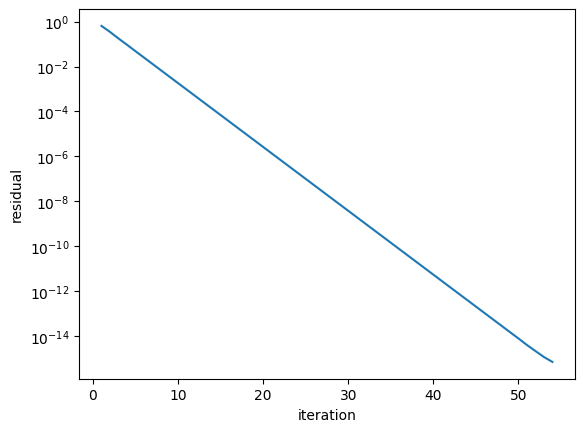

iteration count: 54


In [46]:
def find_solution_by_Jacobi(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    n = A.shape()[0]
    x = x0.copy()
    x_dual = Vector.zeros(n)
    __iteration = 0
    while norm(A * x - f) > eps:
        for i in range(n):
            x_dual[i] = (-sum([A[i, j] * x[j] for j in range(n) if i != j]) + f[i]) / A[i, i]
        x, x_dual = x_dual, x
        __iteration += 1
        add_residual_point(__iteration, norm(A * x - f))
    return x

x = find_solution_by_Jacobi(A, f, Vector.zeros(A.n))
show_result(x)

## Seidel

solution: 
||  0.755370424332477  ||
|| 0.23879962940068056 ||
|| 0.17890324621644077 ||
|| 0.15086987609879332 ||
|| 0.1317093831382963  ||
|| 0.11703320343415916 ||
|| 0.10527116822253554 ||
|| 0.09560544284803442 ||
|| 0.08752165758673965 ||
|| 0.0806659319920251  ||
|| 0.0747830022682031  ||
|| 0.06968321539838078 ||

right part:
|| 1.0000000000000009  ||
|| 0.5000000000000001  ||
|| 0.33333333333333326 ||
|| 0.24999999999999986 ||
|| 0.19999999999999987 ||
|| 0.16666666666666655 ||
|| 0.14285714285714274 ||
|| 0.12499999999999992 ||
|| 0.11111111111111104 ||
|| 0.09999999999999992 ||
|| 0.09090909090909088 ||
|| 0.08333333333333327 ||


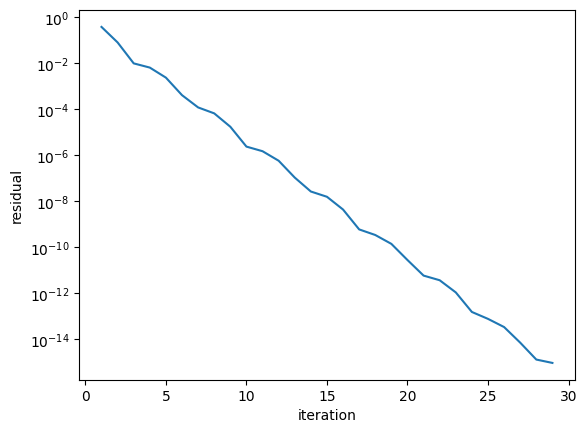

iteration count: 29


In [47]:
def find_solution_by_Seidel(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    n = A.n
    x = x0.copy()
    x_dual = Vector.zeros(n)
    __iteration = 0
    while norm(A * x - f) > eps:
        for i in range(n):
            x_dual[i] = -(sum([A[i, j] * x_dual[j] for j in range(i) if i != j]) 
                          + sum([A[i, j] * x[j] for j in range(i+1, n) if i != j]) 
                          - f[i]) / A[i, i]
        x, x_dual = x_dual, x
        __iteration += 1
        add_residual_point(__iteration, norm(A * x - f))
    return x

x = find_solution_by_Seidel(A, f, Vector.zeros(A.n))
show_result(x)

## successive over-relaxation

solution: 
|| 0.7553704243324755  ||
|| 0.2387996294006804  ||
|| 0.17890324621644085 ||
|| 0.15086987609879357 ||
|| 0.13170938313829658 ||
|| 0.11703320343415945 ||
|| 0.1052711682225357  ||
|| 0.09560544284803463 ||
|| 0.08752165758673983 ||
|| 0.08066593199202526 ||
|| 0.07478300226820322 ||
|| 0.06968321539838093 ||

right part:
|| 0.9999999999999994  ||
|| 0.4999999999999998  ||
|| 0.33333333333333326 ||
|| 0.25000000000000006 ||
|| 0.20000000000000015 ||
|| 0.16666666666666682 ||
|| 0.1428571428571429  ||
|| 0.12500000000000014 ||
|| 0.11111111111111122 ||
|| 0.10000000000000009 ||
|| 0.09090909090909101 ||
|| 0.08333333333333343 ||


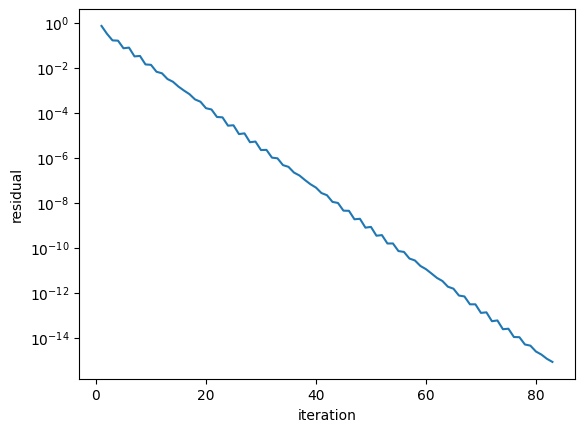

iteration count: 83


In [48]:
def find_solution_by_SOR(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    n = A.n
    x = x0.copy()
    x_dual = Vector.zeros(n)
    __iteration = 0
    while norm(A * x - f) > eps:
        for i in range(n):
            x_dual[i] = (1 - w_SOR) * x[i] - w_SOR * (sum([A[i, j] * x_dual[j] for j in range(i) if i != j]) 
                          + sum([A[i, j] * x[j] for j in range(i+1, n) if i != j]) - f[i]) / A[i, i]
        x, x_dual = x_dual, x
        __iteration += 1
        add_residual_point(__iteration, norm(A * x - f))
    return x

x = find_solution_by_SOR(A, f, Vector.zeros(A.n))
show_result(x)

## gradient descent

solution: 
|| 0.7553704243324753  ||
|| 0.2387996294006812  ||
|| 0.17890324621644105 ||
|| 0.15086987609879357 ||
|| 0.13170938313829653 ||
|| 0.11703320343415938 ||
|| 0.10527116822253567 ||
|| 0.09560544284803459 ||
|| 0.08752165758673977 ||
|| 0.08066593199202521 ||
|| 0.07478300226820317 ||
|| 0.06968321539838085 ||

right part:
|| 0.9999999999999996  ||
|| 0.5000000000000006  ||
|| 0.3333333333333335  ||
|| 0.2500000000000001  ||
|| 0.2000000000000001  ||
|| 0.16666666666666677 ||
|| 0.14285714285714288 ||
|| 0.12500000000000008 ||
|| 0.11111111111111117 ||
|| 0.10000000000000005 ||
|| 0.09090909090909095 ||
|| 0.08333333333333334 ||


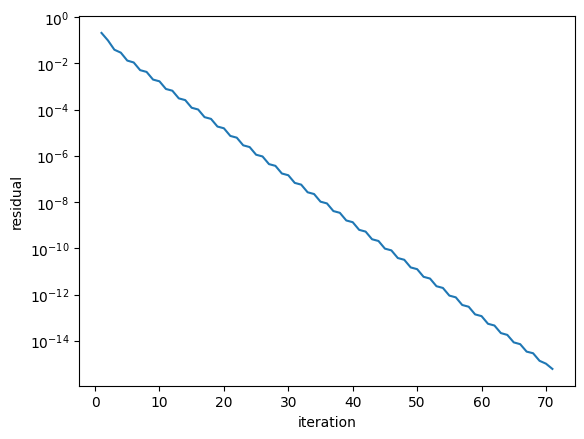

iteration count: 71


In [49]:
def find_solution_by_gradient_descent(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    x = x0
    residual = A * x - f
    __iteration = 0
    while norm(residual) > eps:
        tau = (residual.T() * residual)[0] / ((A * residual).T() * residual)[0]
        x -= tau * residual
        residual = A * x - f
        __iteration += 1
        add_residual_point(__iteration, norm(A * x - f))
    return x

x = find_solution_by_gradient_descent(A, f, Vector.zeros(A.n))
show_result(x)

## minimal residual method

solution: 
|| 0.7553704243324748  ||
|| 0.23879962940068153 ||
|| 0.1789032462164412  ||
|| 0.15086987609879365 ||
|| 0.13170938313829658 ||
|| 0.1170332034341594  ||
|| 0.10527116822253568 ||
|| 0.09560544284803459 ||
|| 0.08752165758673976 ||
|| 0.08066593199202518 ||
|| 0.07478300226820317 ||
|| 0.06968321539838086 ||

right part:
|| 0.9999999999999992  ||
|| 0.5000000000000008  ||
|| 0.33333333333333365 ||
|| 0.25000000000000017 ||
|| 0.20000000000000015 ||
|| 0.1666666666666668  ||
|| 0.1428571428571429  ||
|| 0.12500000000000008 ||
|| 0.11111111111111116 ||
|| 0.10000000000000002 ||
|| 0.09090909090909095 ||
|| 0.08333333333333336 ||


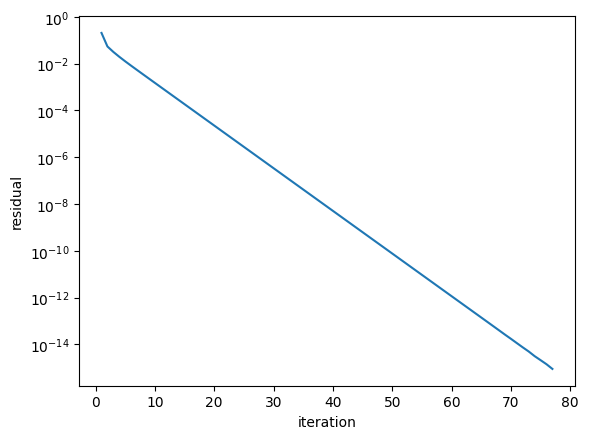

iteration count: 77


In [50]:
def find_solution_by_minimal_residual(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    x = x0
    residual = A * x - f
    __iteration = 0
    while norm(residual) > eps:
        Ar = A * residual
        tau = (Ar.T() * residual)[0] / (Ar.T() * Ar)[0]
        x -= tau * residual
        residual = A * x - f
        __iteration += 1
        add_residual_point(__iteration, norm(A * x - f))
    return x

x = find_solution_by_minimal_residual(A, f, Vector.zeros(A.n))
show_result(x)

## conjugate gradient method

solution: 
|| 0.7553704243324758  ||
|| 0.23879962940068053 ||
|| 0.17890324621644088 ||
|| 0.1508698760987935  ||
|| 0.13170938313829647 ||
|| 0.11703320343415927 ||
|| 0.1052711682225356  ||
|| 0.09560544284803452 ||
|| 0.08752165758673974 ||
|| 0.08066593199202517 ||
|| 0.07478300226820317 ||
|| 0.06968321539838085 ||

right part:
|| 0.9999999999999998  ||
|| 0.4999999999999999  ||
|| 0.3333333333333333  ||
|| 0.24999999999999997 ||
|| 0.20000000000000004 ||
|| 0.16666666666666663 ||
|| 0.1428571428571428  ||
|| 0.12500000000000003 ||
|| 0.11111111111111113 ||
|| 0.09999999999999999 ||
|| 0.09090909090909095 ||
|| 0.08333333333333334 ||


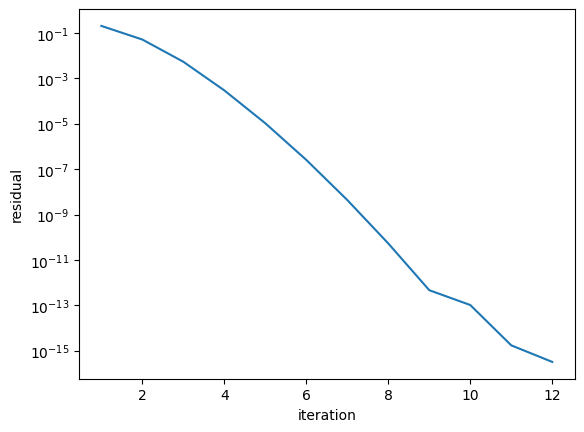

iteration count: 12


In [51]:
def find_solution_by_CG(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    f = A.T() * f
    A = A.T() * A
    x = x0
    residual = A * x - f
    direction = residual.copy()
    r2_old = (residual.T() * residual)[0]
    __iteration = 0
    while norm(residual) > eps:
        Ad = A * direction
        alpha = r2_old / (direction.T() * Ad)[0]
        x -= alpha * direction
        residual -= alpha * Ad
        r2_new = (residual.T() * residual)[0]
        direction = residual + (r2_new / r2_old) * direction
        r2_old = r2_new
        __iteration += 1
        add_residual_point(__iteration, norm(A * x - f))
    return x

x = find_solution_by_CG(A, f, Vector.zeros(A.n))
show_result(x)

## BiCGStab

solution: 
|| 0.7553704243324768  ||
|| 0.23879962940068053 ||
|| 0.17890324621644096 ||
|| 0.15086987609879346 ||
|| 0.1317093831382965  ||
|| 0.11703320343415932 ||
|| 0.1052711682225357  ||
|| 0.09560544284803452 ||
|| 0.08752165758673974 ||
|| 0.0806659319920252  ||
|| 0.07478300226820313 ||
|| 0.06968321539838086 ||

right part:
|| 1.0000000000000009  ||
|| 0.5000000000000001  ||
|| 0.3333333333333335  ||
|| 0.25000000000000006 ||
|| 0.2000000000000001  ||
|| 0.1666666666666667  ||
|| 0.1428571428571429  ||
|| 0.12500000000000003 ||
|| 0.11111111111111115 ||
|| 0.10000000000000003 ||
|| 0.09090909090909093 ||
|| 0.08333333333333336 ||


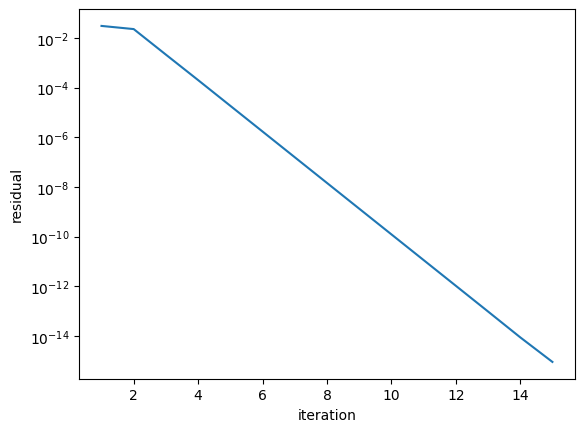

iteration count: 15


In [52]:
def find_solution_by_BiCGStab(A : Matrix, f : Vector, x0 : Vector) -> Vector:
    x = x0
    residualX = A * x - f
    r0 = residualX.T()
    directionX = Vector.zeros(A.n)
    residualY = Vector.zeros(A.n)
    rho_old = 1
    alpha = 1
    omega = 1
    __iteration = 0
    while norm(residualX) > eps:
        rho = (r0 * residualX)[0]
        if abs(rho) < zero_eps:
            raise ValueError("BiCGStab can't solve this system")
        beta = rho / rho_old * alpha / omega
        directionX = residualX + beta * (directionX - omega * residualY)
        residualY = A * directionX
        alpha = rho / (r0 * residualY)[0]
        directionY = residualX - alpha * residualY
        Ady = A * directionY
        omega = (Ady.T() * directionY)[0] / (Ady.T() * Ady)[0]
        x -= alpha * directionX + omega * directionY
        residualX = directionY - omega * Ady
        __iteration += 1
        add_residual_point(__iteration, norm(A * x - f))
    return x

x = find_solution_by_BiCGStab(A, f, Vector.zeros(A.n))
show_result(x)

BiCGStab with $A = A^T > 0$

solution: 
|| 0.7553704243324759  ||
|| 0.23879962940068075 ||
|| 0.17890324621644096 ||
|| 0.1508698760987935  ||
|| 0.13170938313829644 ||
|| 0.11703320343415925 ||
|| 0.1052711682225356  ||
|| 0.09560544284803449 ||
|| 0.08752165758673974 ||
|| 0.08066593199202517 ||
|| 0.07478300226820321 ||
|| 0.06968321539838088 ||

right part:
||         1.0         ||
|| 0.5000000000000001  ||
|| 0.3333333333333334  ||
||        0.25         ||
||         0.2         ||
|| 0.16666666666666663 ||
|| 0.1428571428571428  ||
||        0.125        ||
|| 0.11111111111111113 ||
||         0.1         ||
||  0.090909090909091  ||
|| 0.08333333333333337 ||


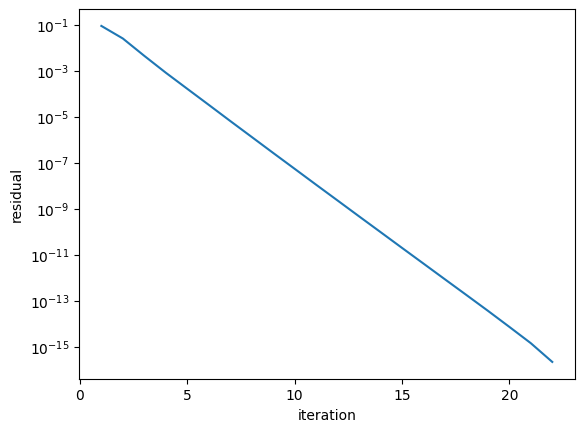

iteration count: 22


In [53]:
x = find_solution_by_BiCGStab(A.T() * A, A.T() * f, Vector.zeros(A.n))
show_result(x)